# 1. Giriş

Sıklıkla birbirine karıştırılan iki kavram öngörü (forecasting) ve tahmin (prediction) kavramlarıdır. Öngörü ile birlikte  

**Tahmin (prediction)**, daha önce görülmemiş test verisi için sonuçların tahmin edilmesiyle ilgilidir. Bu amaçla, yeni $x$ gözlemleri için tahminler yapabilen bir $\hat{f}(x)$ tahmincisi ile sonuçlanan, eğitim veri kümesinde bir model eğitilir.

**Öngörü (forecasting)** problemleri, hem geçmiş verileri kullanan hem de gelecekteki olaylar hakkında konuşan tahmin problemlerinin bir alt kümesidir. Tahmin ve öngörü arasındaki tek fark, öngörüde zamansal boyutun açık bir şekilde dahil edilmesidir. Öngörü, zamana dayalı bir tahmindir, yani zaman serisi verileriyle uğraşırken daha uygundur. Öte yandan, tahminin yalnızca zamana dayalı olması gerekmez, hedef değişkeni etkileyen birden çok nedensel faktöre dayanabilir.

**Şimdigörü (nowcasting)** meteorolojide sıklıkla olmak üzere, ekonomide de kullanılan bir yaklaşımdır. Ekonomide şimdigörü, bir ekonomik göstergenin bugünün, çok yakın geleceğin ve çok yakın geçmişteki durumunun tahminidir. Meteorolojide şimdigörü, tipik olarak +0-6 saatlik bir ufka atıfta bulunan kısa süreli tahmindir. Genellikle en son gözlemlerin ekstrapolasyonu gibi sayısal yöntemleri kullanır ve bir tahminde bulunmak için Lagrange veya Eulerian kalıcılığını varsayar.

Öngörü genel olarak ikiye ayrılabilir: örneklem-içi öngörü ve örneklem-dișı öngörü. Tahmin sürecinde genellikle örneklem-içi performans dikkate alınır. Örneğin, en küçük kareler yönteminde kalıntı kareleri toplamı en küçük yapılarak en iyi örneklem-içi öngörü hesaplanır. Benzer șekilde olabilirlik fonksiyonu en yüksek yapıldığında en iyi örneklem-içi öngörüler olușturulmuș olur. Modellerin karșılaștırımasında bu tür örneklem-içi büyüklükler fazla yardımcı olmayabilir.

Örneklem-dıșı öngörüler rakip modellerin yarștırılmasında kullanılabilir. Öngörü denilince genellikle örneklem-dıșı öngörü anlașılır. Zaman serisinin elimizde $T$ boyutlu sadece bir gerçekleșmesi olduğundan öngörülerin olușturulması için gözlemlerin bir kısmının tahmin için kalanı ise öngörü için kullanılır.  

Bu yazı dizimizin bu kısmında, basit öngörü teknikleri ile başlayıp, ARIMA modelleri ile öngörü ve öngörülerin değerlendirilmesine bakacağız. Basitlik olması adına, meşhur `Air Passengers` verileri ile çalışacağız. Veri kümesine [buradan](https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv) erişebilirsiniz.

Veri kümesini içeri alalım:

In [47]:
import warnings
warnings.filterwarnings("ignore")

# pandas çerçevesinin içeri alınması
import pandas as pd

df = pd.read_csv("AirPassengers.csv", parse_dates=['Month'])
df = df.set_index("Month")
df = df.resample('M').first()
df.head()

,#Passengers
Month,
1949-01-31,112
1949-02-28,118
1949-03-31,132
1949-04-30,129
1949-05-31,121


Seriyi görselleştirelim:

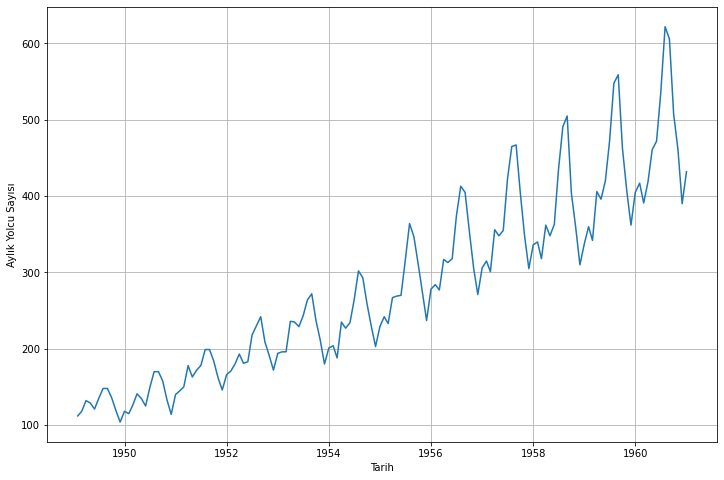

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(df['#Passengers'])
plt.xlabel("Tarih")
plt.ylabel("Aylık Yolcu Sayısı")
plt.grid()

Seiriyi, eğitim ve test veri kümesi olarak iki kümeye bölelim:

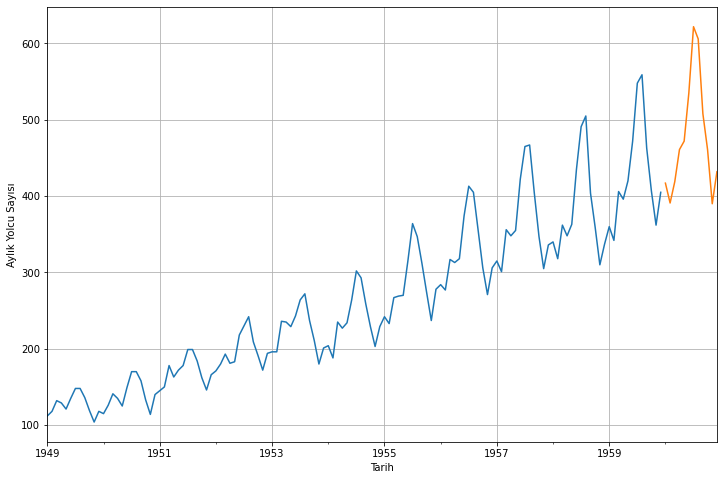

In [49]:
eğitim_verisi = df[df.index < '1960-01-01']
test_verisi   = df[df.index >= '1960-01-01']

eğitim_verisi['#Passengers'].plot(figsize=(12,8))
test_verisi['#Passengers'].plot(figsize=(12,8))
plt.xlabel("Tarih")
plt.ylabel("Aylık Yolcu Sayısı")
plt.grid()
plt.show()

# 2. Basit Öngörü Yöntemleri

## 2.1. Naif Yöntem (Naive Method)

Bu en ilkel öngörü yöntemidir. Naif yöntemin öncülü, beklenen gözlem noktasının son gözlemlenen noktaya eşit olmasıdır:

$$
\hat{y}_{t+1}=y_{t}
$$

Naif yöntem ile yolcu sayılarının öngörüsünü gerçekleştirelim. Bunun için `sktime` çerçevesinden `NaiveForecaster` nesnesini kullanacağız:

In [53]:
import numpy as np
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon

öngörü_dönemi = ForecastingHorizon(test_verisi.index, is_relative=False)
öngörü_modeli = NaiveForecaster(strategy="last")
öngörü_modeli.fit(eğitim_verisi['#Passengers'])
naif_model_öngörüleri = öngörü_modeli.predict(fh=öngörü_dönemi)

Tahminleri, eğitim verisini ve test verisini görselleştirelim:

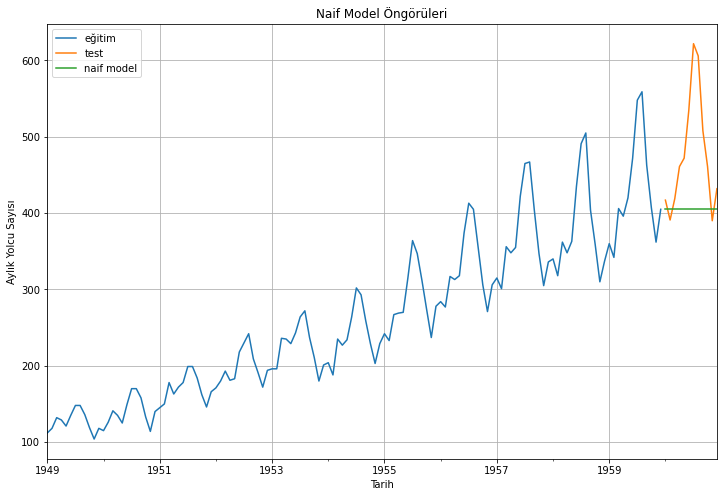

In [59]:
eğitim_verisi['#Passengers'].plot(figsize=(12,8), label="eğitim")
test_verisi['#Passengers'].plot(figsize=(12,8), label="test")
naif_model_öngörüleri.plot(figsize=(12,8), label="naif model")
plt.xlabel("Tarih")
plt.ylabel("Aylık Yolcu Sayısı")
plt.title("Naif Model Öngörüleri")
plt.legend(loc='best')
plt.grid()
plt.show()

## 2.2. Basit Ortalama (Simple Average)

Çoğu zaman, zaman periyodu boyunca küçük bir farkla değişen, ancak her zaman periyodundaki ortalaması sabit kalan bir zaman serisi ile karşılaşılır. Böyle bir durumda, bir sonraki dönemin öngörüsünü, geçmiş dönemlerin ortalamasına yakın bir şekilde öngörebiliriz. 

Önceden gözlemlenen tüm noktaların ortalamasına eşit beklenen değeri öngören bu tür öngörü yaklaşımına **Basit Ortalama (Simple Average)** tekniği denilir:

$$
\hat{y}_{\mathrm{x}+1}=\frac{1}{x} \sum_{i=1}^{x} y_{i}
$$

Basit ortalama ile yolcu sayılarının öngörüsünü gerçekleştirelim:

In [63]:
basit_ortalama_öngörüleri = test_verisi.copy()
basit_ortalama_öngörüleri["basit_ortalama"] = eğitim_verisi["#Passengers"].mean()

Tahminleri, eğitim verisini ve test verisini görselleştirelim:

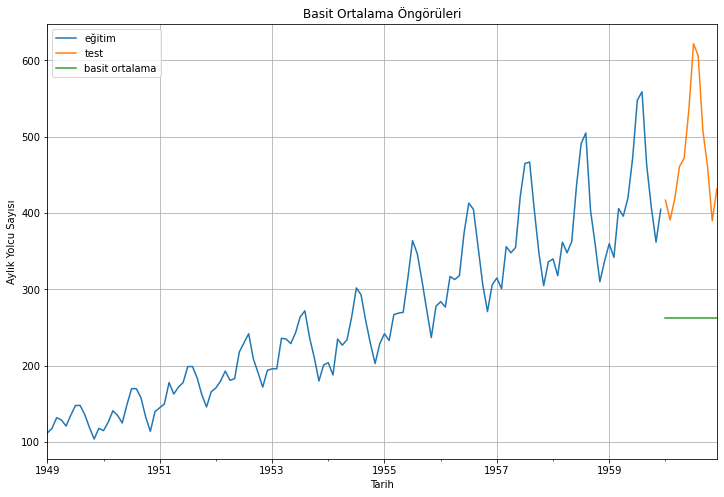

In [65]:
eğitim_verisi['#Passengers'].plot(figsize=(12,8), label="eğitim")
test_verisi['#Passengers'].plot(figsize=(12,8), label="test")
basit_ortalama_öngörüleri["basit_ortalama"].plot(figsize=(12,8), label="basit ortalama")
plt.xlabel("Tarih")
plt.ylabel("Aylık Yolcu Sayısı")
plt.title("Basit Ortalama Öngörüleri")
plt.legend(loc='best')
plt.grid()
plt.show()

## 2.3. Basit Hareketli Ortalama (Simple Moving Average)

Serinin gözlemlerinin birkaç zaman önce keskin bir şekilde arttığı/azaldığı bir veri kümesi ile karşılaşabiliriz. Basit ortalama yöntemini kullanmak için önceki tüm verilerin ortalamasını kullanmalıyız, ancak önceki tüm verileri kullanmak, böyle bir durumda doğru olmaz.

İlk dönem gözlemlerinin kullanılması, bir sonraki dönem için öngörüleri büyük ölçüde etkileyecektir. Bu nedenle, basit ortalamanın üzerinde bir iyileştirme olarak, yalnızca son birkaç dönem için gözlemlerin ortalamasını alacağız. Buradaki temel düşünce, yalnızca son gözlemlerin önemli olduğudur. Ortalamayı hesaplamak için zaman aralığı penceresini kullanan bu tür öngörü yöntemine **Hareketli Ortalama (moving average)** yöntemi denir. Hareketli ortalamanın hesaplanması, bazen $n$ boyutunda "kayan pencere (sliding window)" olarak adlandırılan yöntemi içerir.

Basit hareketli ortalama ile, önceki gözlemlerin sabit sonlu $p$ adedinin ortalamasına dayalı olarak, serideki sonraki değerleri öngörebiliriz. Tüm $i > p$ için:

$$
\widehat{y_{l}}=\frac{1}{p}\left(y_{i-1}+y_{i-2}+y_{i-3} \ldots \ldots+y_{i-p}\right)
$$

Basit hareketli ortalama ile yolcu sayılarının öngörüsünü gerçekleştirelim. Geçmiş 12 dönemi alacağız:

In [66]:
basit_hareketli_ortalama_öngörüleri = test_verisi.copy()
basit_hareketli_ortalama_öngörüleri["basit_hareketli_ortalama"] = eğitim_verisi["#Passengers"].rolling(12).mean().iloc[-1]

Tahminleri, eğitim verisini ve test verisini görselleştirelim:

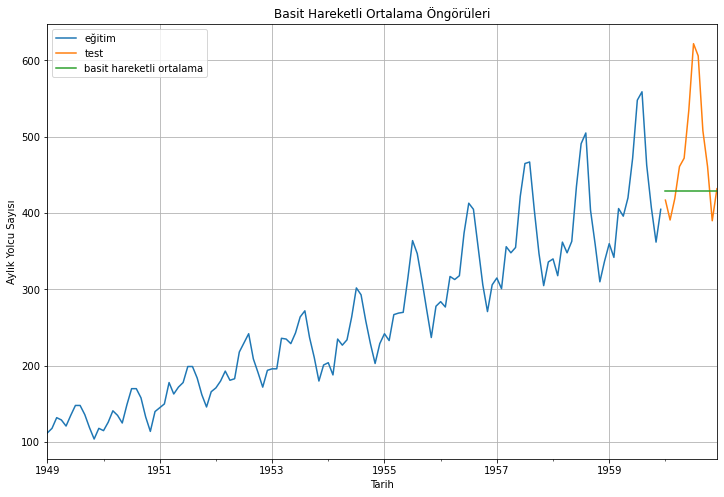

In [68]:
eğitim_verisi['#Passengers'].plot(figsize=(12,8), label="eğitim")
test_verisi['#Passengers'].plot(figsize=(12,8), label="test")
basit_hareketli_ortalama_öngörüleri["basit_hareketli_ortalama"].plot(figsize=(12,8), label="basit hareketli ortalama")
plt.xlabel("Tarih")
plt.ylabel("Aylık Yolcu Sayısı")
plt.title("Basit Hareketli Ortalama Öngörüleri")
plt.legend(loc='best')
plt.grid()
plt.show()

Hareketli ortalama yöntemine göre bir adım daha bir iyileştirme, ağırlıklı hareketli ortalama yöntemidir. Hareketli ortalama yönteminde, geçmiş $n$ adet gözlemi eşit olarak tartıyoruz. Ancak geçmişteki $n$ gözlemin her birinin, öngörüleri farklı bir şekilde etkilediği durumlarla karşılaşabiliriz. Geçmiş gözlemleri farklı şekilde tartan bu yaklaşıma **Ağırlıklı Hareketli Ortalama (Weighted Moving Average)** denilir.

Ağırlıklı hareketli ortalama, kayan pencere içindeki gözlemlere farklı ağırlıkların verildiği, genel olarak daha yeni noktaların daha önemli olduğu bir hareketli ortalamadır:

$$
\widehat{y_{l}}=\frac{1}{m}\left(w_{1} * y_{i-1}+w_{2} * y_{i-2}+w_{3} * y_{i-3} \ldots \ldots+w_{m} * y_{i-m}\right)
$$

## 2.5. Üstel Düzgünleştirme (Exponential Smoothing)

Gözlem noktalarını farklı şekilde tartarken tüm gözlemleri hesaba katan bu hareketli ortalama ve ağırlıklı hareketli ortalama yaklaşımları arasında bir şeye ihtiyacımız olur. Örneğin, uzak geçmişten gelen gözlemlere göre daha yakın tarihli gözlemlere daha büyük ağırlıklar vermek mantıklı olabilir. Bu prensibe göre çalışan yaklaşım, **Basit Üstel Düzgünleştirme (Simple Exponential Smoothing)** olarak adlandırılır. Öngörüler, ağırlıklı ortalamalar kullanılarak hesaplanır, burada gözlemler geçmişten geldikçe üstel olarak azalır, en küçük ağırlıklar en eski gözlemlerle ilişkilendirilir:

$$
\hat{y}_{t+1 \mid t}=\alpha y_{t}+\alpha(1-\alpha)_{y_{t}-1}+\alpha(1-\alpha)^{2}{y_{t}-2}+\cdots
$$

Burada, $0 \leq \alpha \leq 1$, düzgünleştirme parametresidir.

Basit üstel düzgünleştirme ile yolcu sayılarının öngörüsünü gerçekleştirelim. Burada $\alpha$ parametresini iki şekilde belirleyeceğiz: ilkinde el ile, ikincisinde ise `statsmodels` çerçevesinin parametreyi ayarlamasını sağlayarak:

In [72]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

basit_üstel_düzgünleştirme1 = SimpleExpSmoothing(eğitim_verisi['#Passengers'], initialization_method="heuristic")
basit_üstel_düzgünleştirme2 = SimpleExpSmoothing(eğitim_verisi['#Passengers'], initialization_method="estimated")

basit_üstel_düzgünleştirme_öngörüleri = test_verisi.copy()
model1 = basit_üstel_düzgünleştirme1.fit(smoothing_level=0.6, optimized=False)
basit_üstel_düzgünleştirme_öngörüleri["basit_üstel_düzgünleştirme1"] = model1.forecast(len(test_verisi))
model2 = basit_üstel_düzgünleştirme2.fit()
basit_üstel_düzgünleştirme_öngörüleri["basit_üstel_düzgünleştirme2"] = model2.forecast(len(test_verisi))

Tahminleri, eğitim verisini ve test verisini görselleştirelim:

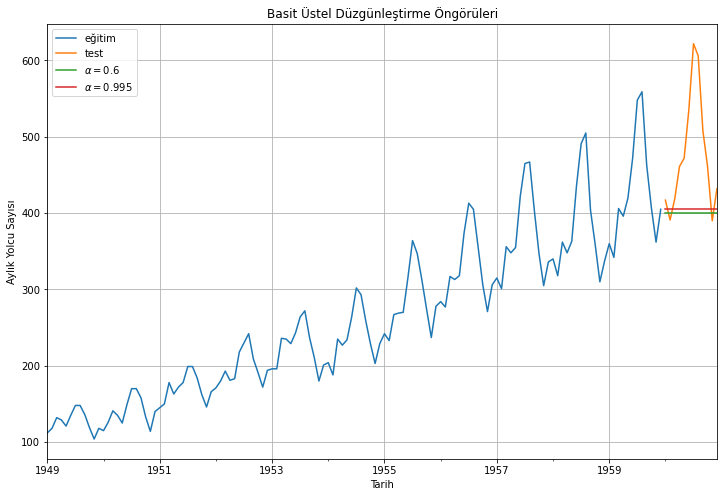

In [74]:
eğitim_verisi['#Passengers'].plot(figsize=(12,8), label="eğitim")
test_verisi['#Passengers'].plot(figsize=(12,8), label="test")
basit_üstel_düzgünleştirme_öngörüleri["basit_üstel_düzgünleştirme1"].plot(figsize=(12,8), label=r"$\alpha=0.6$")
basit_üstel_düzgünleştirme_öngörüleri["basit_üstel_düzgünleştirme2"].plot(figsize=(12,8), label=r"$\alpha=0.995$")
plt.xlabel("Tarih")
plt.ylabel("Aylık Yolcu Sayısı")
plt.title("Basit Üstel Düzgünleştirme Öngörüleri")
plt.legend(loc='best')
plt.grid()
plt.show()

## 2.6. Holt Doğrusal Trend Yöntemi

Holt, trendi dikkate alarak, gelecek dönem öngörülerini gerçekleştirmek için basit üstel düzügünleştirme yaklaşımını gliştirir. Bu yaklaşım, hem seviyeye (serideki ortalama değer) hem de trende uygulanan üstel düzgünleştirmeden başka bir şey değildir. Bunu matematiksel gösterimle ifade etmek için şimdi üç denkleme ihtiyacımız var: biri seviye için, biri trend için ve biri de beklenen öngörüyü elde edecek şekilde için seviye ve trendi birleştirmek için $ŷ$:

$$
\text{Öngörü denklemi :} \hat{y}_{t+h \mid t}=\ell_{t}+h b_{t}
$$

$$
\text{Seviye denklemi :} \ell_{t}=\alpha y_{t}+(1-\alpha)\left(\ell_{t-1}+b_{t-1}\right)
$$

$$
\text{Trend denklemi :} b_{t}=\beta *\left(\ell_{t}-\ell_{t-1}\right)+(1-\beta) b_{t-1}
$$

Holt doğrusal trend yöntemi ile yolcu sayılarının öngörüsünü gerçekleştirelim:

In [81]:
holt = Holt(eğitim_verisi['#Passengers']).fit(smoothing_level = 0.9,smoothing_slope = 0.01)

holt_öngörüleri = test_verisi.copy()
holt_öngörüleri["holt"] = holt.forecast(len(test_verisi))

Tahminleri, eğitim verisini ve test verisini görselleştirelim:

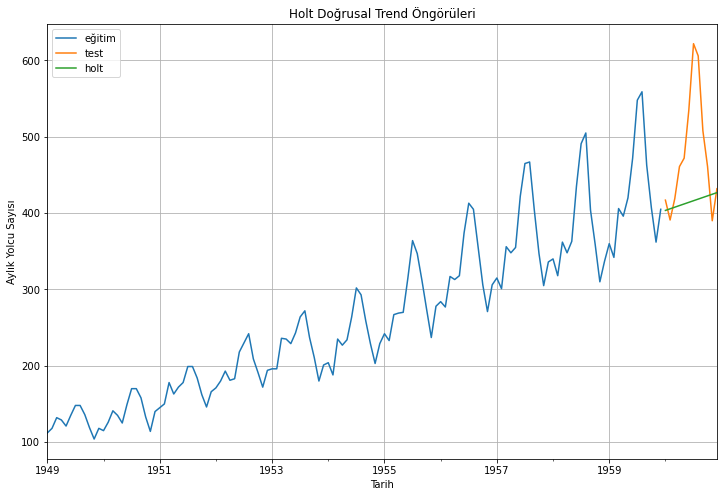

In [82]:
eğitim_verisi['#Passengers'].plot(figsize=(12,8), label="eğitim")
test_verisi['#Passengers'].plot(figsize=(12,8), label="test")
holt_öngörüleri["holt"].plot(figsize=(12,8), label="holt")
plt.xlabel("Tarih")
plt.ylabel("Aylık Yolcu Sayısı")
plt.title("Holt Doğrusal Trend Öngörüleri")
plt.legend(loc='best')
plt.grid()
plt.show()

## 2.7. Holt-Winters Yöntemi

Yukarıda bahsedilen modeller, öngörüleri gerçekleştirirken gözlemlerin mevsimselliğini hesaba katmaz. Dolayısıyla, gelecekteki gözlemleri öngörmek için hem trendi hem de mevsimselliği hesaba katan bir yönteme ihtiyacımız var. Böyle bir senaryoda kullanabileceğimiz böyle bir algoritma Holt'un Winters yöntemidir. Üçlü üstel düzgünleştirmenin (triple exponential smoothing-Holt's Winter) arkasında yatan teml fikir, seviye ve trende ek olarak mevsimsel bileşenlere üstel düzgünleştirme uygulamaktır.

Mevsimsellik faktörü nedeniyle Holt-Winters yöntemini kullanmak diğer modeller arasında en iyi seçenek olacaktır. Holt-Winters mevsimsel yöntemi, bir önörü denkleminden, ve biri $\ell_{t}$ düzeyi için, biri trend $b_{t}$ için ve diğeri α, β ve γ yumuşatma parametreleriyle birlikte $s_{t}$ ile gösterilen mevsimsel bileşen için olmak üzere üç düzleştirme denkleminden oluşur.

$$
\begin{aligned}
\text { seviye } \quad L_{t} &=\alpha\left(y_{t}-S_{t-s}\right)+(1-\alpha)\left(L_{t-1}+b_{t-1}\right) \\
\text { trend } \quad b_{t} &=\beta\left(L_{t}-L_{t-1}\right)+(1-\beta) b_{t-1} \\
\text { mevsimsel } \quad S_{t} &=\gamma\left(y_{t}-L_{t}\right)+(1-\gamma) S_{t-s} \\
\text { öngörü } F_{t+k} &=L_{t}+k b_{t}+S_{t+k-s}
\end{aligned}
$$

Holt-Winters yöntemi ile yolcu sayılarının öngörüsünü gerçekleştirelim:

In [85]:
holt_winters = ExponentialSmoothing(eğitim_verisi['#Passengers'], 
                                    seasonal_periods=12, 
                                    trend='add', 
                                    seasonal='mul', 
                                    initialization_method="estimated").fit()

holt_winters_öngörüleri = test_verisi.copy()
holt_winters_öngörüleri["holt_winters"] = holt_winters.forecast(len(test_verisi))

Tahminleri, eğitim verisini ve test verisini görselleştirelim:

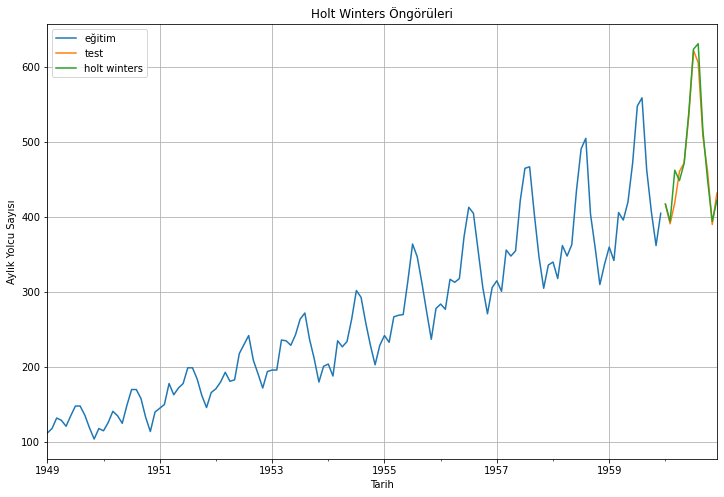

In [90]:
eğitim_verisi['#Passengers'].plot(figsize=(12,8), label="eğitim")
test_verisi['#Passengers'].plot(figsize=(12,8), label="test")
holt_winters_öngörüleri["holt_winters"].plot(figsize=(12,8), label="holt winters")
plt.xlabel("Tarih")
plt.ylabel("Aylık Yolcu Sayısı")
plt.title("Holt Winters Öngörüleri")
plt.legend(loc='best')
plt.grid()
plt.show()

# 3.ARIMA Modelleri ile Öngörü

Durağan doğrusal modeller yardimıyla $y_{t}$ 'nin gelecek değerlerine ilișkin öngörü olușturmak istediğimizi düșünelim.

Box ve Jenkins'in geliștirdiği $\operatorname{ARIMA}(p, d, q)$ modelleme yaklașımının pratikteki amacı çoğunlukla öngörü olușturmaktır.

$j$ dönem sonrası için öngörü olușturmak isteyen arastırmacının bilgi kümesinde $t$ dönemi ve ön cesine ilișkin $y_{t}$ değerlerinin yer aldığını vars ayalım Öng örü hata varyansını en küçük yapan öngörünün $y_{t+j}$ 'nin koșullu beklentisi olduğu kolayca gösterilebilir. Bir bașka ifadeyle, olușturulacak öng örü așağıdaki gibi yazıabilir:

$$
\mathrm{E}\left(y_{t+j} \mid y_{t}, y_{t-1}, y_{t-2}, \ldots, y_{1}\right) \equiv \mathrm{E}_{t}\left(y_{t+j}\right)
$$

Örnek olarak $y_{t} \sim A R(1)$ olduğunu düșünelim:

$$
y_{t}=c+\phi y_{t-1}+\epsilon_{t}, \quad \epsilon_{t} \sim w n\left(0, \sigma^{2}\right)
$$

$j=1$ dönemi için model:

$$
y_{t+1}=c+\phi y_{t}+\epsilon_{t+1}
$$

Bir dönem sonrası için koșullu beklenen değer:

$$
\mathrm{E}_{t}\left(y_{t+1}\right)=c+\phi y_{t}
$$

ve öngörü hatası

$$
e_{t}(1)=y_{t+1}-\mathrm{E}_{t}\left(y_{t+1}\right)=\epsilon_{t+1}
$$

Benzer șekilde $j=2$ iccin model ve koșullu beklenen değer, sırasıyla:

$$
\begin{aligned}
y_{t+2}=& c+\phi y_{t+1}+\epsilon_{t+2} \\
\mathrm{E}_{t}\left(y_{t+2}\right) &=c+\mathrm{E}_{t}\left(y_{t+1}\right) \\
&=c+\phi\left(c+\phi y_{t}\right) \\
&=c(1+\phi)+\phi^{2} y_{t}
\end{aligned}
$$

Öng örü hatası ise

$$
\begin{aligned}
& e_{t}(2)=c+\phi y_{t+1}+\epsilon_{t+2}, \\
e_{t}(2)=& y_{t+2}-\mathrm{E}_{t}\left(y_{t+2}\right) \\
=& c+\phi y_{t+1}+\epsilon_{t+2}-c(1+\phi)-\phi^{2} y_{t} \\
=& \phi(\underbrace{\left.y_{t+1}-c-\phi y_{t}\right)}_{\epsilon_{t+1}}+\epsilon_{t+2}\\
=& \phi \epsilon_{t+1}+\epsilon_{t+2}
\end{aligned}
$$

Genel olarak $j$ dönem sonrası için koșullu beklenen değer (öngörü):

$$
\mathrm{E}_{t}\left(y_{t+j}\right)=c\left(1+\phi+\phi^{2}+\ldots+\phi^{j-1}\right)+\phi^{j} y_{t}
$$

Açktır ki $|\phi|<1$ durağanlik koșulu altında $\mathrm{AR}(1)$ modelinin öngörü fonksiyonu $j$ limitsiz büyürken koșulsuz beklentiye yaklașır:

$$
j \rightarrow \infty, \quad \mathrm{E}_{t}\left(y_{t+j}\right) \rightarrow \mathrm{E}\left(y_{t}\right)=\frac{c}{1-\phi}
$$

dönem sonrası için öngörü hatasının:

$$
e_{t}(j)=\epsilon_{t+j}+\phi \epsilon_{t+j-1}+\phi^{2} \epsilon_{t+j-2}+\ldots+\phi^{j-1} \epsilon_{t+1}
$$

olduğu gösterilebilir.

Gelecekte ne kadar uzağa öngörü yapılirsa yapilsın öngörü hatasının beklenen değeri sıfırdır. Ancak, öngörünün değișkenliği $j$ ile birlikte artmaktadır. Genel durum için öngörü hatasının varyansı

$$
\operatorname{Var}\left(e_{t}(j)\right)=\sigma^{2}\left(1+\phi+\phi^{2}+\phi^{4}+\ldots+\phi^{2(j-1)}\right)
$$

olur 1 - dönem sonrası için öngörü varyansı $\sigma^{2}$ iken 2 - dönem sonrası için öngörü varyansı $\sigma^{2}\left(1+\phi^{2}\right)$ olmaktadır. Öngörü ufku arttıkça belirsizlik de artmaktadır. Limitte öngörü varyansının koșulsuz varyansa yaklașacağı açıktır:

$$
j \rightarrow \infty, \quad \operatorname{Var}\left(e_{t}(j)\right) \rightarrow \frac{\sigma^{2}}{1-\phi^{2}}
$$

$\epsilon_{t}$ 'nin normal dağıldığı varsayımı altında olușturulan öngörüler için standart güven aralıkları hesaplanabilir.

Genel $\operatorname{ARMA}(p, q)$ modelleri çerçevesinde olușturulan öngörüler de benzer yapıya sahiptir. Durağan modellerde $y_{t+j}$ 'nin koșullu beklenen değeri $j$ artarken ARMA sürecinin koșulsuz beklentisine yaklașmaktadır. Ayrıca öngörü ufku arttıkça öngörülerin kesinliği azalmaktadır. Pratikte yakın dönemlere ilișkin öngörü olușturulması tercih edilir.

ARIMA üzerinde bir geliştürme, Mevsimsel ARIMA (Seasonal ARIMA)' dır. Holt-Winters yöntemi gibi gözlemlerin mevsimselliğini hesaba katar.

Mevrimsel ARIMA (SARIMAX) yöntemi ile yolcu sayılarının öngörüsünü gerçekleştirelim:

In [89]:
import statsmodels.api as sm

sarima_modeli = sm.tsa.statespace.SARIMAX(eğitim_verisi['#Passengers'], order=(2, 1, 4),seasonal_order=(0,1,1,12)).fit()

sarima_öngörüleri = test_verisi.copy()
sarima_öngörüleri["sarima"] = sarima_modeli.predict(start="1960-01-31", end="1960-12-31", dynamic=True)

Tahminleri, eğitim verisini ve test verisini görselleştirelim:

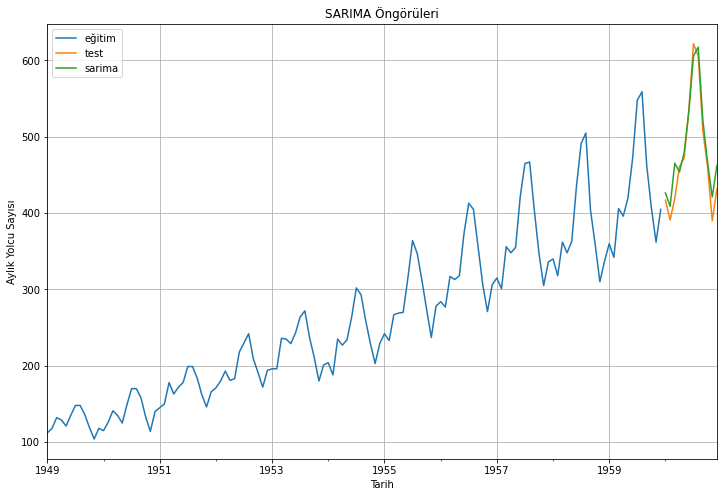

In [91]:
eğitim_verisi['#Passengers'].plot(figsize=(12,8), label="eğitim")
test_verisi['#Passengers'].plot(figsize=(12,8), label="test")
sarima_öngörüleri["sarima"].plot(figsize=(12,8), label="sarima")
plt.xlabel("Tarih")
plt.ylabel("Aylık Yolcu Sayısı")
plt.title("SARIMA Öngörüleri")
plt.legend(loc='best')
plt.grid()
plt.show()

# 3.Öngörülerin Değerlendirilmesi

Box-Jenkins yaklașımında gözlemlenen serilerdeki dinamiği iyi yakalayan (white noise kalıntılı) ve fazla büyük olmayan modellerin tercih edilmesi önerilir. Uygulamada bu özellikleri sağlayan birden fazla rakip ARMA modellerine ulașılabilir. Bu modeller arasından hangisinin seçileceğine bilgi kriterleri $(\mathrm{AlC}, \mathrm{SBC}$, etc) yardımcı olabilir. Bunun yanı sıra, rakip modeller öngörü performansları açısından da karșıaștırılabilir.

1-dönem sonrası öngörüler için pratikte takip edilecek adımlar șöyle sıralanabilir:

1. Aday modelleri belirle: $M_{1}, M_{2}$
2. Tahminde kullanılacak örneklem hacmini $\left(T_{1}\right)$ belirle (not:
$n=T-T_{1}$ dönem için 1 -dönem sonrasına öngörüler olușturulacaktır.)
3. $i=1 \mathrm{icin} T_{1}+i-1$ gözlemden hareketle $M_{1}$ ve $M_{2}$ modellerini tahmin et, ve 1 dönem sonrası icin öngörüyü oluștur. Bunlara sırasıyla, $\hat{y}_{T_{1}+1}^{(1)}$ ve $\hat{y}_{T_{1}+1}^{(2)}$ ile gösterelim. Öngörü hataları her iki alternatif model için sırasıyla
$$
e_{1}^{(1)}=y_{T_{1}+1}-\hat{y}_{T_{1}+1}^{(1)}, \quad e_{1}^{(2)}=y_{T_{1}+1}-\hat{y}_{T_{1}+1}^{(2)}
$$
4. $i=2,3, \ldots, n$ icin 2 . ve 3. adımları tekrarla. Her tahminde örneklem boyutuna bir gözlemin eklendiğine dikkat edilmelidir. Bu hesapla maların sonucunda elimizde $n$ boyutlu öngörü ve hata serileri olacaktır:
$$
\begin{array}{ll}
\left\{\hat{y}_{t}^{(1)}\right\}_{t=T_{1}+1}^{T}, & \left\{e_{i}^{(1)}\right\}_{i=1}^{n} \\
\left\{\hat{y}_{t}^{(2)}\right\}_{t=T_{1}+1}^{T}, & \left\{e_{i}^{(2)}\right\}_{i=1}^{n}
\end{array}
$$
5. Öngörü hatalarından hareketle alternatif modellerin performanslarını karșılaștır.

Öngörü performanslarının karșıaștırıImasında çeșitli ölçütler ve testler kullanılmaktadır. Yaygın olarak kullanılan ölçütler șunlardır:

Hata Karelerinin Ortalamasının Karekökü (Root Mean Squared Error)
$$
R M S E=\sqrt{\frac{1}{n} \sum_{i=1}^{n} e_{i}^{2}}
$$

Mutlak Hatanın Ortalaması (Mean Absolute Error):
$$
M A E=\frac{1}{n} \sum_{i=1}^{n}\left|e_{i}\right|
$$

Kestirim Hatalarının Karelerinin Ortalaması (Mean Squared Prediction Error):
$$
M S P E=\frac{1}{n} \sum_{i=1}^{n} e_{i}^{2}
$$

Bu formüllerde $e_{i}$ öngörü hatasını göstermektedir.

$e_{i}=(t+i)$ zamanında gözlenen değer- $(t+i)$ zama nında öngörülen değer

Yukarıda gerçekleştirmiş olduğumuz öngörüleri, RMSE ölçütü bazında karşılaştıralım:

In [95]:
from sklearn.metrics import mean_squared_error
from math import sqrt

naif_yöntem_performansı = sqrt(mean_squared_error(test_verisi['#Passengers'], 
                                                  naif_model_öngörüleri))
basit_ortalama_performansı = sqrt(mean_squared_error(test_verisi['#Passengers'], 
                                                     basit_ortalama_öngörüleri.basit_ortalama))
basit_hareketli_ortalama_performansı = sqrt(mean_squared_error(test_verisi['#Passengers'], 
                                                              basit_hareketli_ortalama_öngörüleri.basit_hareketli_ortalama))
basit_üstel_düzgünleştirme_performansı1 = sqrt(mean_squared_error(test_verisi['#Passengers'], 
                                                                 basit_üstel_düzgünleştirme_öngörüleri.basit_üstel_düzgünleştirme1))
basit_üstel_düzgünleştirme_performansı2 = sqrt(mean_squared_error(test_verisi['#Passengers'], 
                                                                 basit_üstel_düzgünleştirme_öngörüleri.basit_üstel_düzgünleştirme2))
holt_performansı = sqrt(mean_squared_error(test_verisi['#Passengers'], 
                                           holt_öngörüleri.holt))
holt_winters_performansı = sqrt(mean_squared_error(test_verisi['#Passengers'], 
                                                   holt_winters_öngörüleri.holt_winters))
sarima_performansı = sqrt(mean_squared_error(test_verisi['#Passengers'], 
                                             sarima_öngörüleri.sarima))
öngörü_performansı = pd.DataFrame(
    {
        "model" : ["naif yöntem", "basit ortalama", "basit hareketli_ortalama", "basit üstel düzgünleştirme1", 
                   "basit üstel düzgünleştirme2", "holt", "holt winters", "sarima"],
        "performans" : [naif_yöntem_performansı, basit_ortalama_performansı, basit_hareketli_ortalama_performansı,
                       basit_üstel_düzgünleştirme_performansı1, basit_üstel_düzgünleştirme_performansı2, holt_performansı,
                       holt_winters_performansı, sarima_performansı]
    }
)

print(öngörü_performansı.sort_values(by="performans"))

                         model  performans
6                 holt winters   15.809645
7                       sarima   20.765954
2     basit hareketli_ortalama   88.473160
5                         holt   95.413292
0                  naif yöntem  102.976535
4  basit üstel düzgünleştirme2  103.124454
3  basit üstel düzgünleştirme1  106.127007
1               basit ortalama  226.265671


RMSE ölçütüne göre, en düşük hata Holt Winters yöntemi ile elde edilen öngörüler ile elde edilmiştir.

Modellerin değerlendirilmesinde başka istatistiksel ölçütler de kullanılabilir. Bunlardan bazıları F testi, Granger-Newbold testi, Diebold-Mariano testi ve Uzun Dönem Varyans testidir.

## 3.1.F Testi

Elimizde rakip iki model olduğunu düșünelim ve bunlara ait MSPE değerlerini sırasyla, $M S P E_{1}$ ve $M S P E_{2}$ ile gösterelim.

Öngörü performanslarının aynı olduğunu söyleyen boș hipotez altında MSPE değerlerinin oranı $(n, n)$ serbestlik derecesiyle $F$ dağılımına uyar:

$$
\frac{M S P E_{1}}{M S P E_{2}} \sim F(n, n)
$$

Boș hipotezin reddedilmesi $M S P E_{1}$ 'in $M S P E_{2}$ 'den daha büyük olduğu anlamına gelir. Bu durumda daha kücük öngörü hata varyansına sahip olan ikinci model tercih edilir.

Ancak, bu testin geçerli olması için așağıdaki varsayımların sağlanması șarttır:

1. Öngörü hataları sıfır ortalama ile normal dağılıma uyar,
2. Farklı modellerden elde edilen öngörü hataları cari dönem itibariyle ilișkisizdir,
3. Öngörü hatalarında dizisel korelasyon yoktur.

Özellikle 2. ve 3. varsayımların sağlanmaması sonucu MSPE oranları F dağılımına uymaz ve test geçersiz olur. Literatürde çeșitli öngörü testleri önerilmiștir.

## 3.2.Granger-Newbold (GN) Testi

Cari dönem itibariyle ilișkili olmasına izin vermektedir ancak öngörü hatalarında otokorelasyon olmamalıdır.
$e_{1 i}$ ve $e_{2 i}$ rakip iki modelden elde edilen öngörü hataları olmak üzere GN testi așağıdaki iki ya pay zaman serisine dayanır:

$$
\begin{array}{l}
z_{i}^{+}=e_{1 i}+e_{2 i}, \quad i=1,2, \ldots, n \\
z_{i}^{-}=e_{1 i}-e_{2 i}, \quad i=1,2, \ldots, n
\end{array}
$$

Öngörü hatalarının normal dağılması ve dizisel özilintinin olmaması varsayımları altında $z_{i}^{+}$ ve $z_{i}^{-}$ serilerinin ilișkisiz olması beklenir.

Populasyon korelasyon katsayısı
$$
\rho=\mathrm{E}\left(z_{i}^{+} z_{i}^{-}\right)=\left(e_{1 i}^{2}-e_{2 i}^{2}\right)
$$

$\rho=0$ ise öngörü performansları eșittir. $\rho>0$ ise ilk modelin varyansı daha büyüktür $\left(M S P E_{1}>M S P E_{2}\right) . \rho<0$ ise ikinci modelin varyansı daha büyüktür $\left(M S P E_{1}<M S P E_{2}\right)$. $H_{0}: \rho=0$ hipotezi altında GN test istatistiği

$$
G N=\frac{\hat{\rho}}{\sqrt{\left(1-\hat{\rho}^{2}\right) /(n-1)}} \sim t_{n-1}
$$

Burada $\hat{\rho}$ örneklem korelasyon katsayısıdır. Pozitif ve anlamlı bir sonuc çıkarsa ikinci model tercih edilecektir ( $M S P E_{1}$ daha büyük). Negatif ve anlamlı bir sonuç çıkarsa birinci model tercih edilecektir.

Testin anlamsız çıkması öngörü performanslarının eșdeğer olduğuna ișaret eder.

## 3.3.Diebold-Mariano (DM) Testi

$\left\{e_{1 i}\right\}_{i=1}^{n}$ ve $\left\{e_{2 i}\right\}_{i=1}^{n}$ rakip iki modelden elde edilen öngörü hataları olsun.

DM testi bu iki öngörü hatası serisinden hareketle hesaplanan loss fonksiyonlarını karșılaștırır. $L_{i}^{j} j$ modelinden elde edilen loss fonksiyonu olmak üzere DM test istatistigi öngörü performansının eșit olup olmadığını test eder:

$$
\begin{array}{l}
H_{0}: \mathrm{E}\left(d_{i}\right)=0 \\
H_{1}: \mathrm{E}\left(d_{i}\right) \neq 0
\end{array}
$$

Burada $d_{i}$ kullanıan kriter fonksiyonları arasındaki farktır:

$$
d_{i}=L_{i}^{1}-L_{i}^{2}
$$

Pratikte yaygın olarak karesel, mutlak hata ya da dördüncü kuvvet kriter (loss) fonksiyonları kullanılır:

$$
L_{i}=e_{i}^{2}, \quad L_{i}=\left|e_{i}\right|, \quad L_{i}=e_{i}^{4}
$$

DM test istatistiğinin hesa planması oldukça basittir. Loss fonksiyonları arasındaki farkın standardize edilmesine dayanır. Öngörü hatalarında otokorelasyon olduğundan DM uzun dönem varyans tahmin edicisinin kulla nılmasını önermișlerdir. DM test istatistiği șu șekilde hesaplanır:

$$
D M=\frac{\bar{d}}{\sqrt{L \hat{R} V(\bar{d}) /(n-1)}}
$$

Burada $L \hat{R} V$ uzun dönem varyansının (long run variance) bi tahminidir.

## 3.4.Uzun Dönem Varyans (Long Run Variance-LRV)

$y_{t}$ durağan ve ergodik bir zaman serisi ise gösterilebilir ki

$$
\sqrt{T}(\bar{y}-\mu) \stackrel{d}{\longrightarrow} N\left(0, \sum_{j=-\infty}^{\infty} \gamma_{j}\right)
$$
ya da

$$
\bar{y} \stackrel{a}{\sim} N\left(\mu, \frac{1}{T} \sum_{j=-\infty}^{\infty} \gamma_{j}\right)
$$

Uzun dönem varyansı ise
$$
L R V_{y}=T \cdot \frac{1}{T} \sum_{j=-\infty}^{\infty} \gamma_{j}=\sum_{j=-\infty}^{\infty} \gamma_{j}
$$

$\gamma_{-j}=\gamma_{j}$ olduğundan așaıdaki gibi yazılabilir:

$$
L R V_{y}=\gamma_{0}+2 \sum_{j=1}^{\infty} \gamma_{j}
$$

$L R V$ 'nin tahmininde parametrik ya da parametrik olmayan yöntemler kullanılabilir. Serideki otokorelasyonun yapısını temsil edebilen yeterince uz un gecikmeye sahip bir $\mathrm{AR}(\mathrm{p})$ modeli tahmin edilerek așağıdaki gibi hesaplanabilir.

$$
L \hat{R} V_{y}=\frac{\hat{\sigma}^{2}}{\left(1-\hat{\phi}_{1}-\hat{\phi}_{2}-\ldots-\hat{\phi}_{p}\right)^{2}}
$$

Burada $\hat{\phi}_{j}$ AR katsay ılarının tahminidir. Alternatif bir parametrik olmayan tahmin edici Newey ve West
(1987) tarafından önerilmiștir:

$$
L \hat{R} V_{y}=\hat{\gamma}_{0}+2 \sum_{j=1}^{q} w_{j} \hat{\gamma}_{j}
$$

$w_{j}$ otokovaryansların ağırlıklarını, $q$ ise pencere aralığını temsil etmektedir. Newey-West Bartlett ağırlıklarını önermiștir:

$$
w_{j}=1-\frac{j}{q+1}
$$

Pratikte pencere araluıının seçiminde $q=4(T / 100)^{2 / 9}$ formülü kullanıabilir (tamsayı kısmı).